In [1]:
from gc import callbacks
import os
import cv2
# for reading and processing images
#import imageio
from PIL import Image
from skimage.io import imread,imsave
from skimage.transform import rescale, resize
# for visualizations
import matplotlib.pyplot as plt
import re
import numpy as np # for using np arrays
import glob
# for bulding and running deep learning model
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.losses import binary_crossentropy
from sklearn.model_selection import train_test_split
#from stardist.models import StarDist2D 
#from stardist.plot import render_label
#from csbdeep.utils import normalize
#from skimage.segmentation import find_boundaries

2022-02-25 12:02:35.776573: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-25 12:02:35.776595: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def LoadData_predict (path1):
    """
    Looks for relevant filenames in the shared path
    Returns 2 lists for original and masked files respectively
    """
    # Make a list for images and masks filenames
    bright_img = []
    
    
    r = re.compile(r'r(\d+)c(\d+)f(\d+)p(\d+)-ch(\d+)sk(\d+)')
    def custom_key(x):
        val = int(r.search(x).group(5)) * 100_000_000 + int(r.search(x).group(1)) * 10_000_000 + int(r.search(x).group(2)) * 100_000 + int(r.search(x).group(3)) * 1_000 + int(r.search(x).group(6))
        return val
    def custom_key2(x):
        val = int(r.search(x).group(1)) * 1_000_000 + int(r.search(x).group(2)) * 100_000 + int(r.search(x).group(3)) * 1_000 + int(r.search(x).group(6))
        return val
    # Read the images folder like a list
    for filename in sorted(glob.glob(path1 + '*.tiff'), key = lambda x: custom_key(x)):
        #print (filename)
        if (int(r.search(filename).group(2))) < 6:
            continue
        
        if (int(r.search(filename).group(2))) == 6:
            if (int(r.search(filename).group(1))) < 6:
                continue
        if (int(r.search(filename).group(2))) == 11:
            if (int(r.search(filename).group(1))) > 3:
                continue
            
        if (int(r.search(filename).group(5)) == 2):
            bright_img.append(filename)
    # Sort the lists to get both of them in same order (the dataset has exactly the same name for images and corresponding masks)
    bright_img.sort(key = lambda x: custom_key2(x))
    
    return bright_img

In [3]:
def ProcessData(bright, target_shape_img, target_shape_mask, path1, model):
    # Pull the relevant dimensions for image and mask
    m = len(bright)                     
    i_h, i_w, i_c = target_shape_img
    m_h, m_w, m_c = target_shape_mask
    print (i_h, i_w, i_c)
    print (m_h, m_w, m_c)
    # Define X and Y as number of images along with shape of one image
    X = np.zeros((m, i_h, i_w, i_c), dtype=np.float32)
    y = np.zeros((m, m_h, m_w, m_c), dtype=np.int32)
    # Resize images and masks
    for file in bright:
        # convert image into an array of desired shape (3 channels)
        index = bright.index(file)
        image_bright_field = imread(file)
        image_bright_field = resize(image_bright_field, (i_h, i_w),
                       anti_aliasing=True)
        image_bright_field = np.reshape(image_bright_field,(i_h, i_w, i_c)) 
        image_bright_field = np.float64(image_bright_field)
        image_bright_field = image_bright_field / image_bright_field.max()
        #X[index] = image_bright_field
        #X[index] = image_bright_field
        image_bright_field = image_bright_field[np.newaxis, ...]
        pred_y = model.predict(image_bright_field)
        
        pred_mask = tf.argmax(pred_y[0], axis = -1)
        pred_mask = pred_mask[..., tf.newaxis]
        
        #print (pred_mask)
        img = pred_mask[:,:,0]
        
        #fig, arr = plt.subplots(1, 2, figsize=(35, 35))
        #arr[0].imshow(X[index])
        #arr[0].set_title('Processed Image')
        #arr[1].imshow(pred_mask[:,:,0])
        #arr[1].set_title('Predicted Masked Image ')
        #plt.savefig('plot{}.png'.format(index))
        #img = np.where(img == 1, img, 255)
        #imsave(os.path.basename(file), img)
        
        img = (np.array(img)*255).astype(np.uint8)
        
        cv2.imwrite('/media/nk/TNF_experiments_II/NG/JW163__2022-02-18T14_49_40-Measurement 1/pred/'+os.path.basename(file), img)
    return X

In [4]:
# Call the apt function
path1 = '/media/nk/TNF_experiments_II/NG/JW163__2022-02-18T14_49_40-Measurement 1/Images/'

bright = LoadData_predict (path1)
print ('Count of Bright field imaged:',  len(bright))

Count of Bright field imaged: 3276


/media/nk/TNF_experiments_II/NG/JW163__2022-02-18T14_49_40-Measurement 1/Images/r02c08f07p01-ch2sk6fk1fl1.tiff
(1080, 1080)


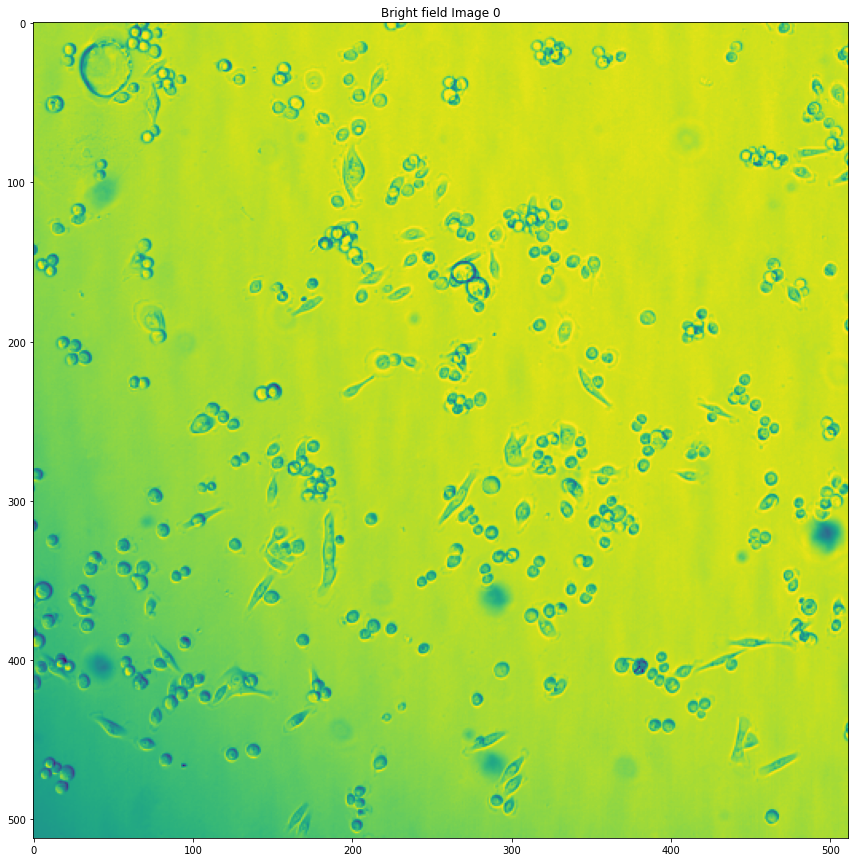

In [5]:
# View an example of image and corresponding mask 
show_images = 1
print(bright[200])
for i in range(show_images):
    img_view  = imread(bright[200])
    image_resized = resize(img_view, (512, 512),
                       anti_aliasing=True)
    print(img_view.shape)
    #print(mask_view.shape)
    fig, arr = plt.subplots(1, 1, figsize=(15, 15))
    arr.imshow(image_resized)
    arr.set_title('Bright field Image '+ str(i))

In [6]:
# Define the desired shape
target_shape_img = [512,512, 1]
target_shape_mask = [512, 512, 1]
unet = tf.keras.models.load_model('my_model_PC9.h5')
# Process data using apt helper function
X = ProcessData(bright, target_shape_img, target_shape_mask, path1, unet)

2022-02-25 12:02:38.994160: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-02-25 12:02:38.994182: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-25 12:02:38.994206: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (SysBioSig-Precision-Tower-5810): /proc/driver/nvidia/version does not exist
2022-02-25 12:02:38.994825: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


512 512 1
512 512 1


In [ ]:
unet = tf.keras.models.load_model('my_model_PC9.h5')

In [ ]:
# Results of Validation Dataset
def VisualizeResults(index):
    img = X[index]
    img = img[np.newaxis, ...]
    pred_y = unet.predict(img)
    pred_mask = tf.argmax(pred_y[0], axis = -1)
    pred_mask = pred_mask[..., tf.newaxis]
    #imsave(pred_mask[:,:,0], '')
    fig, arr = plt.subplots(1, 3, figsize=(35, 35))
    arr[0].imshow(X_valid[index])
    arr[0].set_title('Processed Image')
    arr[2].imshow(pred_mask[:,:,0])
    arr[2].set_title('Predicted Masked Image ')
    plt.savefig('plot{}.png'.format(index))

In [ ]:
for i in range (len(X_valid)):
    VisualizeResults(i) 